<a href="https://colab.research.google.com/github/sumitmandloism/US500-Transformer-Model-base/blob/main/US500_transformerM15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# necessary libraries
!pip install tensorflow==2.14.0
!pip install yfinance
!pip install vectorbt
!pip install pandas_ta
!pip install matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: google-auth-oauthlib
    Found existing ins

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=efe2ada660f0e032d62b1f54a28332e6243904df45cb8bd4090740efcd43a80f
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta
^C


In [16]:

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# ES Futures data from Yahoo Finance
ticker = "ES=F"  # S&P 500 Futures
es_data = pd.read_csv("/content/US500M15.csv")

# Checking for missing data and drop missing rows
es_data.dropna(inplace=True)

# Converting 'Volume' column to numeric, handling errors
es_data['Volume'] = pd.to_numeric(es_data['Volume'], errors='coerce')

# Calculating returns
# Shift the returns calculation back by 1 to align with feature data
es_data['Return'] = es_data['Close'].pct_change().shift(-2) # Shifted back by 2


# Drop rows with NaN values caused by return calculation and shift
es_data.dropna(inplace=True)

# Check if the dataframe is empty after dropping NaN values
if es_data.empty:
    print("DataFrame is empty after dropping NaN values. Check your data or calculations.")
else:
    # OHLCV features for the model
    features = es_data[['Open', 'High', 'Low', 'Close', 'Volume']].values
    returns = es_data['Return'].values

    # OHLCV features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # sliding windows for time series (50 timesteps window size)
    def sliding_windows(data, labels, window_size):
        X, y = [], []
        for i in range(len(data) - window_size):
            X.append(data[i:i + window_size])
            y.append(labels[i + window_size])
        return np.array(X), np.array(y)

    window_size = 50
    X, y = sliding_windows(features_scaled, returns, window_size)

    # data into training, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

    print(X_train.shape, X_val.shape, X_test.shape)

(18548, 50, 5) (2319, 50, 5) (2319, 50, 5)


# New section

In [17]:
import tensorflow as tf

# custom Transformer block layer
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"),
             tf.keras.layers.Dense(embed_dim)]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Transformer-based model for time series prediction
def transformer_model(seq_len, num_features, embed_dim, num_heads, ff_dim, num_blocks):
    inputs = tf.keras.Input(shape=(seq_len, num_features))
    x = tf.keras.layers.Dense(embed_dim)(inputs)  # Linear transformation

    for _ in range(num_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(1)(x)  # Predict the next return

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Hyperparameters for the model
seq_len = 50
num_features = 5
embed_dim = 64
num_heads = 8
ff_dim = 128
num_blocks = 4

# Creating and compiling the model
model = transformer_model(seq_len, num_features, embed_dim, num_heads, ff_dim, num_blocks)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 5)]           0         
                                                                 
 dense_10 (Dense)            (None, 50, 64)            384       
                                                                 
 transformer_block_4 (Trans  (None, 50, 64)            149504    
 formerBlock)                                                    
                                                                 
 transformer_block_5 (Trans  (None, 50, 64)            149504    
 formerBlock)                                                    
                                                                 
 transformer_block_6 (Trans  (None, 50, 64)            149504    
 formerBlock)                                                    
                                                           

In [21]:
#  callbacks for early stopping and learning rate adjustment
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=5, min_lr=1e-6)
]

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=callbacks)


Epoch 1/50
580/580 [==============================] - 260s 449ms/step - loss: 2.6770e-04 - val_loss: 4.4031e-06 - lr: 0.0010
Epoch 2/50
580/580 [==============================] - 272s 470ms/step - loss: 1.5847e-04 - val_loss: 4.1526e-06 - lr: 0.0010
Epoch 3/50
580/580 [==============================] - 266s 458ms/step - loss: 1.0617e-04 - val_loss: 6.4276e-06 - lr: 0.0010
Epoch 4/50
580/580 [==============================] - 269s 464ms/step - loss: 9.1562e-05 - val_loss: 9.6816e-05 - lr: 0.0010
Epoch 5/50
580/580 [==============================] - 267s 460ms/step - loss: 5.5769e-05 - val_loss: 3.7303e-05 - lr: 0.0010
Epoch 6/50
580/580 [==============================] - 259s 446ms/step - loss: 5.4315e-05 - val_loss: 8.3254e-05 - lr: 0.0010
Epoch 7/50
580/580 [==============================] - 273s 471ms/step - loss: 2.2460e-05 - val_loss: 5.9845e-05 - lr: 2.0000e-04
Epoch 8/50
580/580 [==============================] - 267s 461ms/step - loss: 1.9668e-05 - val_loss: 2.1970e-05 - lr: 2.0

73/73 [==============================] - 9s 127ms/step - loss: 1.0708e-06
Test Loss: 1.0707697128964355e-06
73/73 [==============================] - 10s 130ms/step


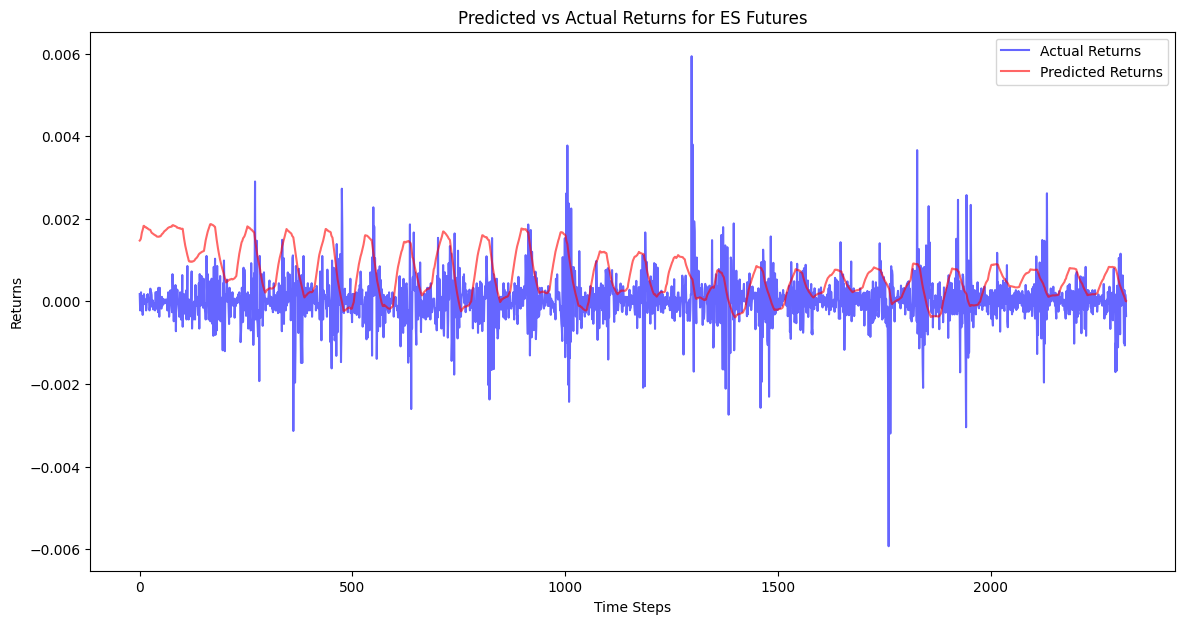

In [22]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# predictions on the test set
y_pred = model.predict(X_test)

# Plot of predicted vs actual returns
plt.figure(figsize=(14, 7))

# Plot actual returns (blue line)
plt.plot(y_test, label='Actual Returns', color='blue', alpha=0.6)

# Plot predicted returns (red line)
plt.plot(y_pred, label='Predicted Returns', color='red', alpha=0.6)

# Adding labels and title
plt.title("Predicted vs Actual Returns for ES Futures")
plt.xlabel("Time Steps")
plt.ylabel("Returns")

# Adding legend
plt.legend()

#  plot
plt.show()


In [23]:
import vectorbt as vbt

#  test close prices and signals for backtesting
close_prices = es_data['Close'].values[-len(X_test):]  # Corresponding close prices for the test set
entry_signal = y_pred > 0  # Go long if predicted return > 0
exit_signal = y_pred <= 0  # Exit if predicted return <= 0

# backtest
portfolio = vbt.Portfolio.from_signals(close_prices, entry_signal.flatten(), exit_signal.flatten())

# save performance metrics
portfolio_stats = portfolio.stats()
print(portfolio_stats)

# equity curve
portfolio.plot().show()


Start                            0.000000
End                           2318.000000
Period                        2319.000000
Start Value                    100.000000
End Value                      102.925385
Total Return [%]                 2.925385
Benchmark Return [%]             4.658358
Max Gross Exposure [%]         100.000000
Total Fees Paid                  0.000000
Max Drawdown [%]                 1.734092
Max Drawdown Duration          739.000000
Total Trades                    11.000000
Total Closed Trades             10.000000
Total Open Trades                1.000000
Open Trade PnL                   0.099263
Win Rate [%]                    50.000000
Best Trade [%]                   2.836233
Worst Trade [%]                 -0.706899
Avg Winning Trade [%]            1.061446
Avg Losing Trade [%]            -0.492643
Avg Winning Trade Duration     140.400000
Avg Losing Trade Duration      201.000000
Profit Factor                    2.130767
Expectancy                       0

In [24]:
# Saving the trained model
model.save('es_transformer_model')

# Saving backtest results as HTML
portfolio.plot().write_html('backtest_results.html')

#files from Colab
from google.colab import files
files.download('es_transformer_model')
files.download('backtest_results.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>